RvR: Stolen useful script from Lindsay's notebooks

In [1]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
import katdal
import katpoint
import scape

#User Input

In [3]:
filename = '/var/kat/archive/data/MeerKATAR1/telescope_products/2016/02/01/1454365764.h5'
antenna_name='m062'

#Processing Script

In [4]:
nd_models = '/var/kat/katconfig/user/noise-diode-models/mkat/'
h5 = katdal.open(filename,centre_freq=1284.0e6)

/usr/lib/pymodules/python2.7/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/scape/fitting.py:1871: RuntimeWarning: invalid value encountered in sqrt
  std_params = np.sqrt(np.diag(self._interp.cov_params))


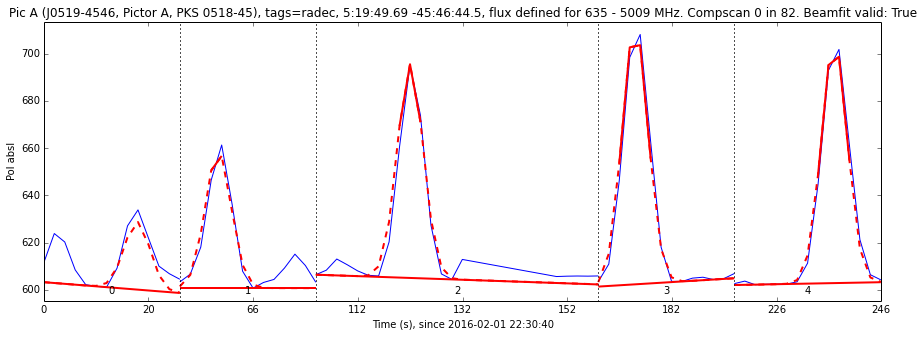

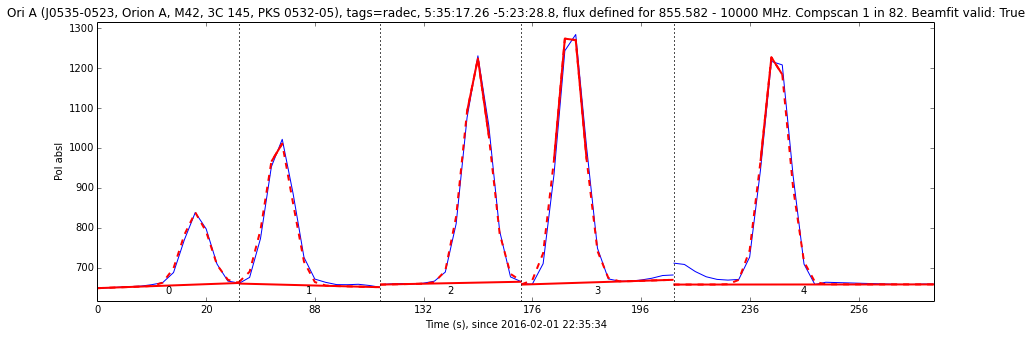

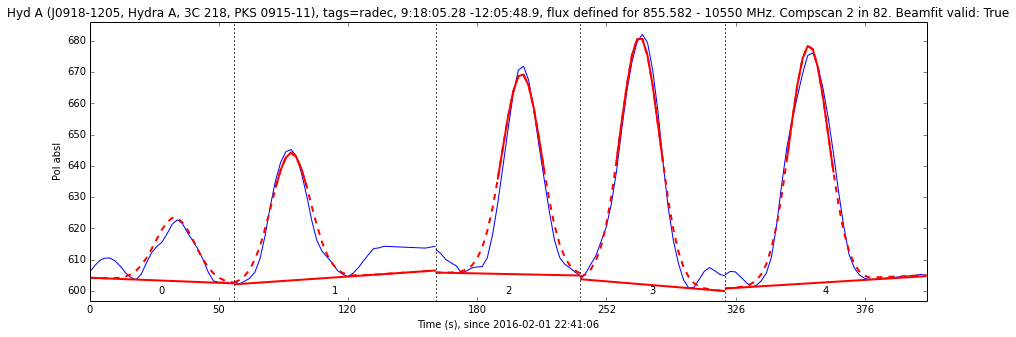

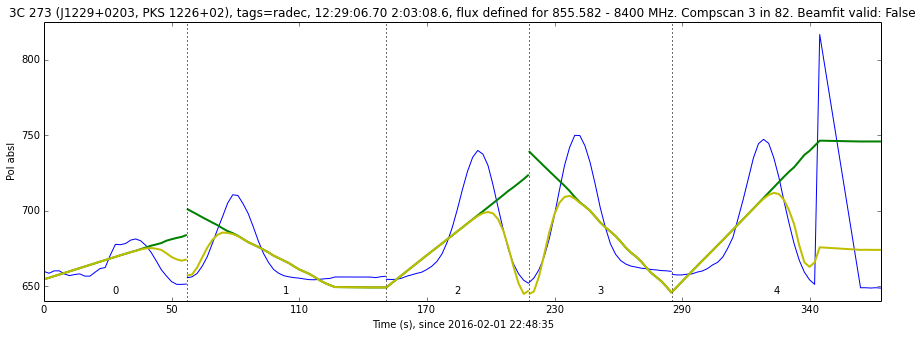

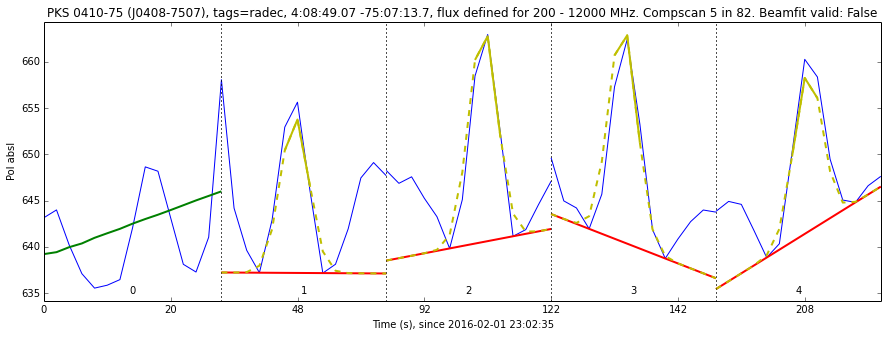

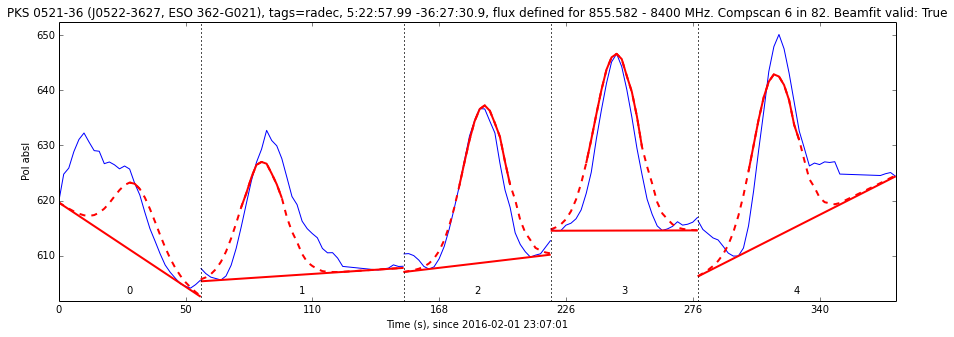

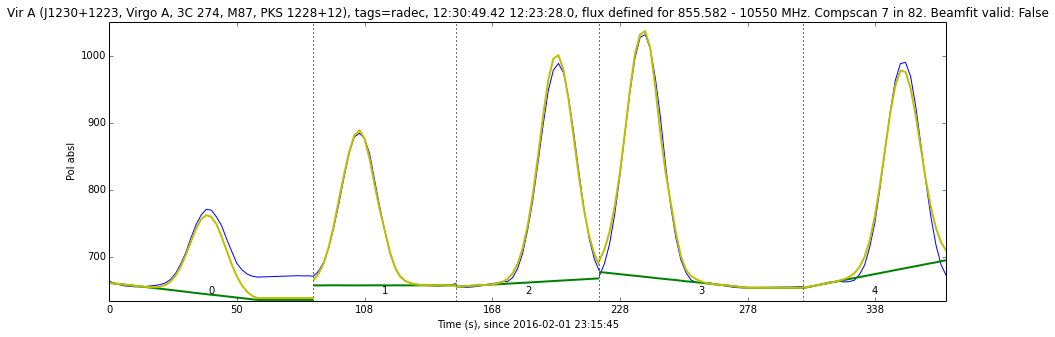

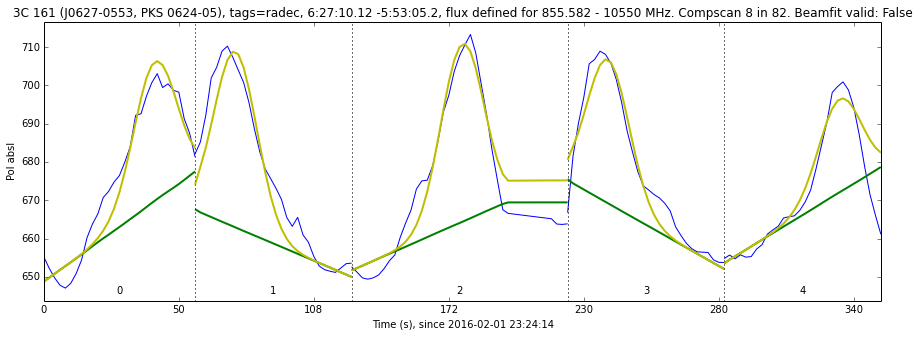

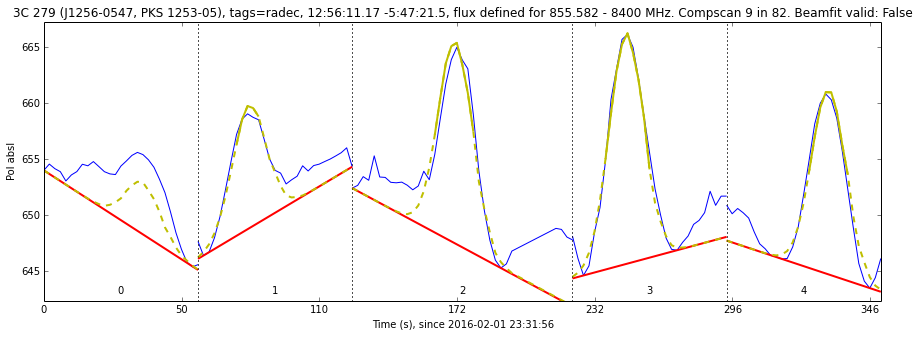

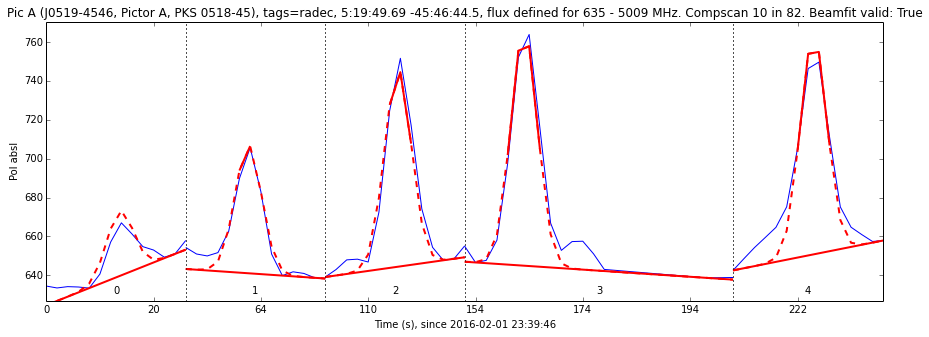

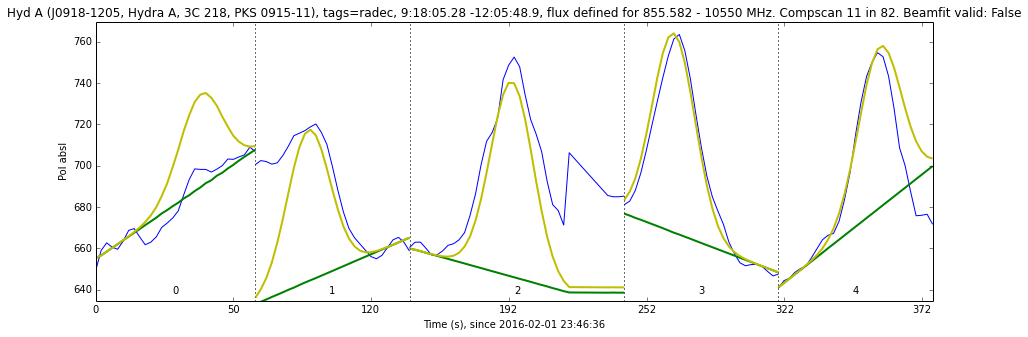

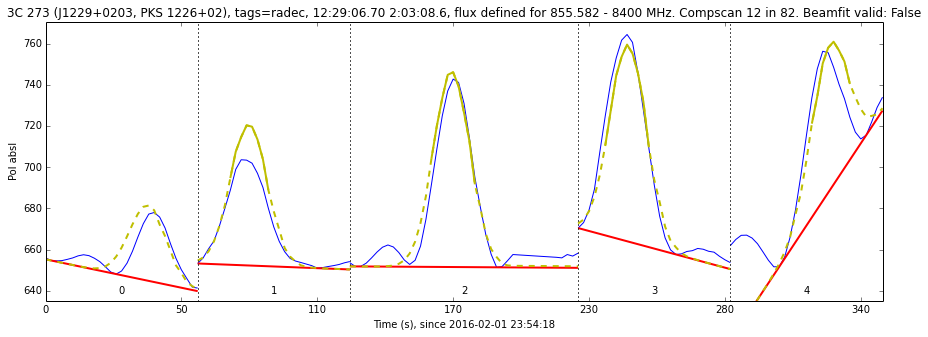

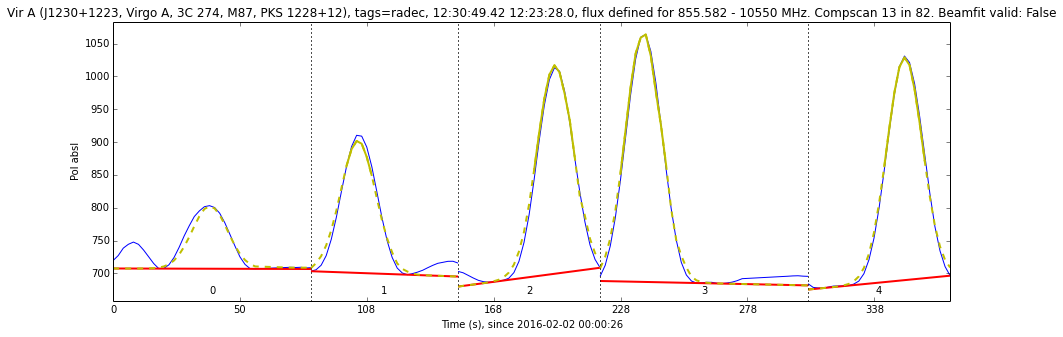

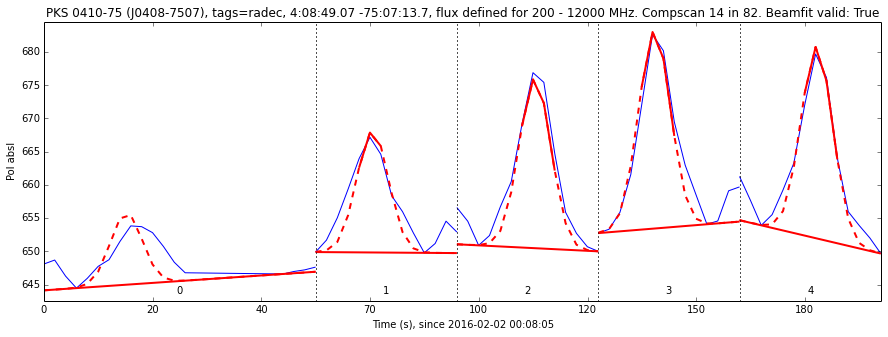

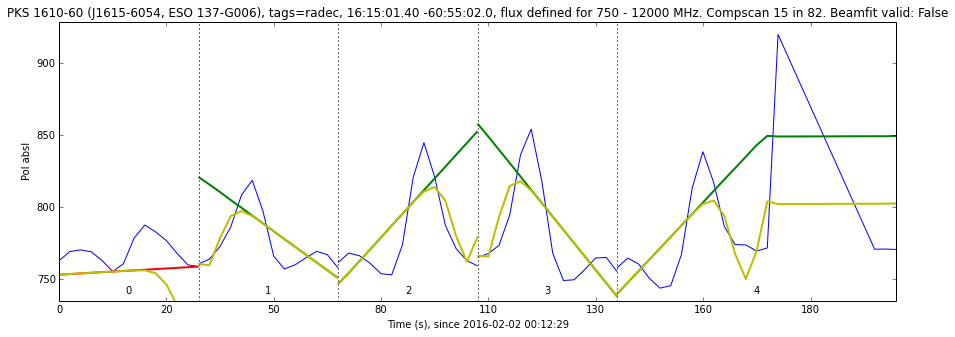

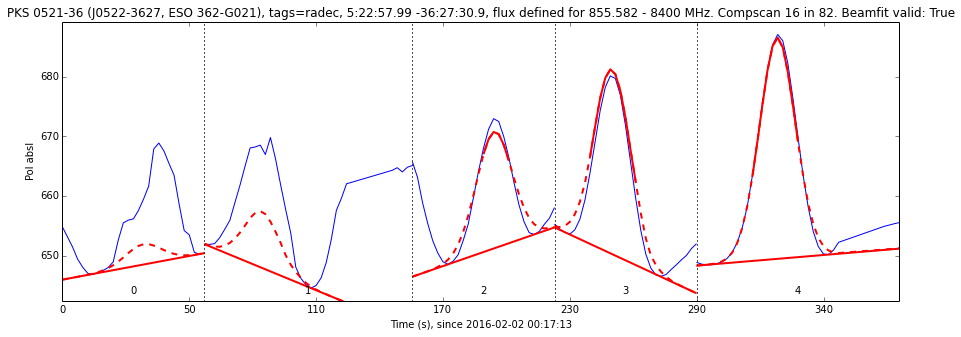

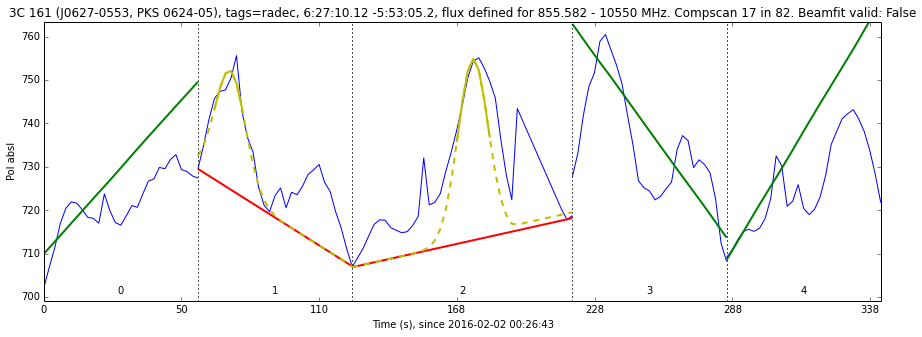

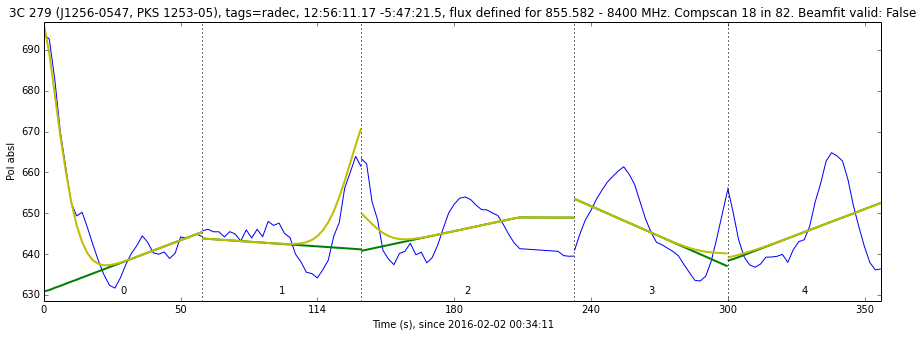

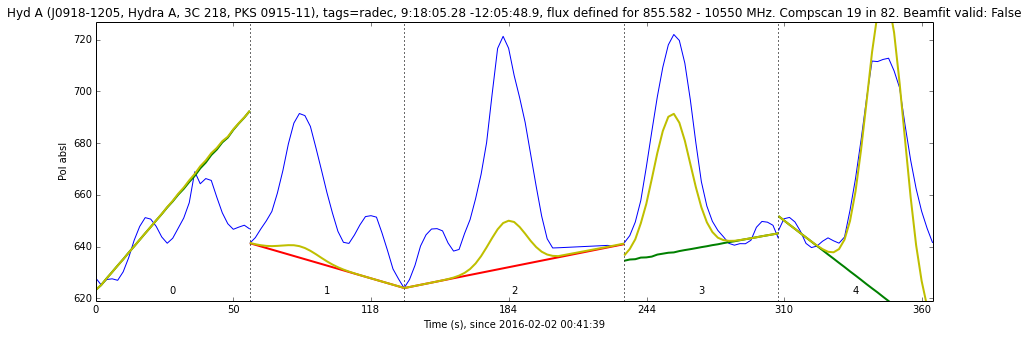

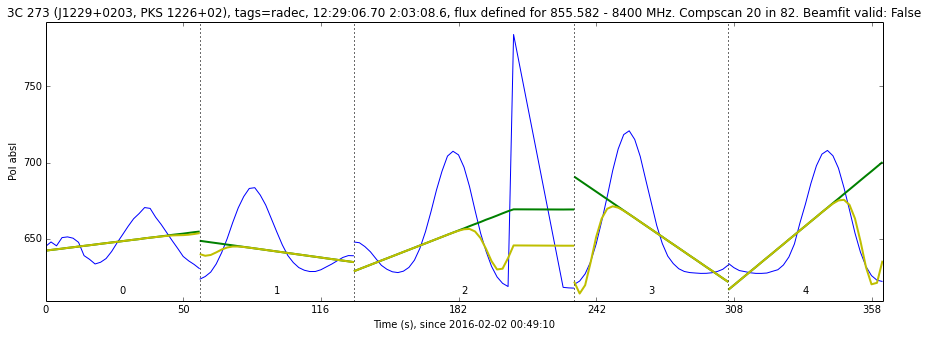

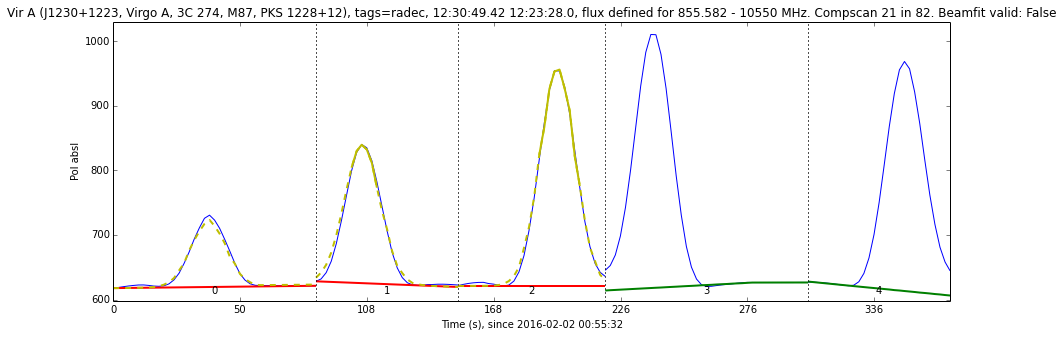

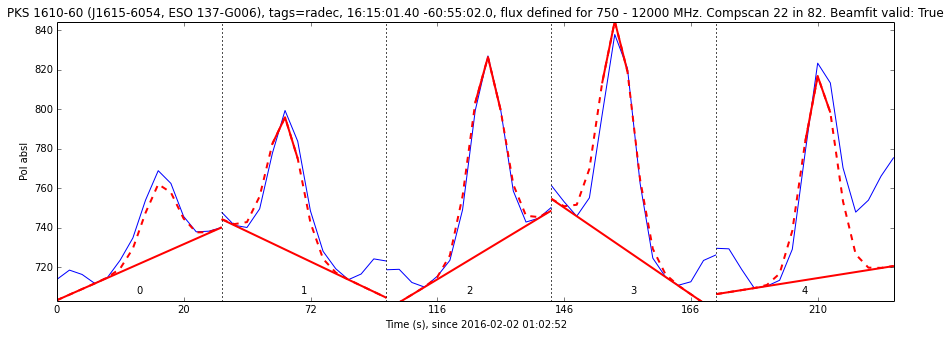

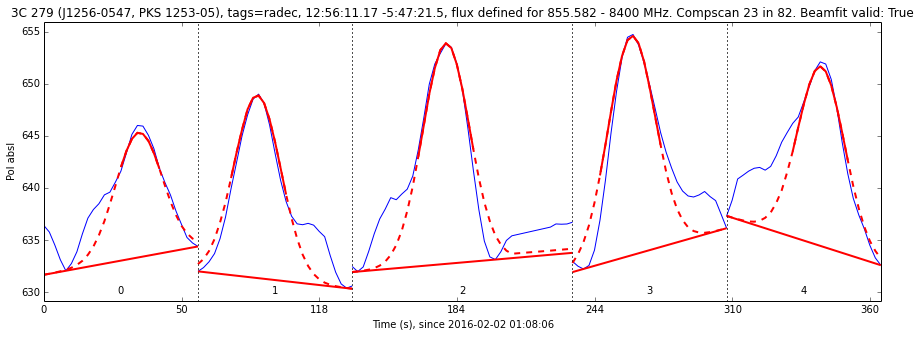

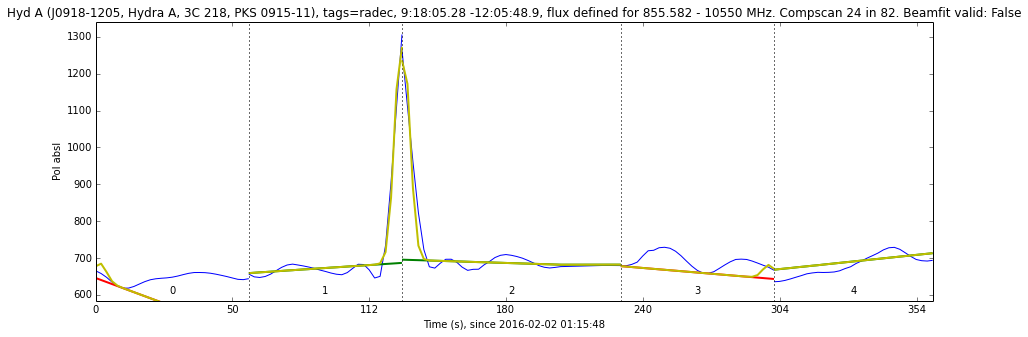

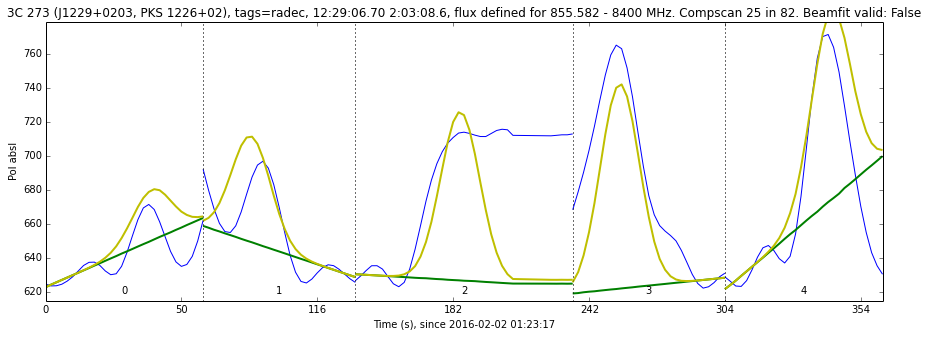

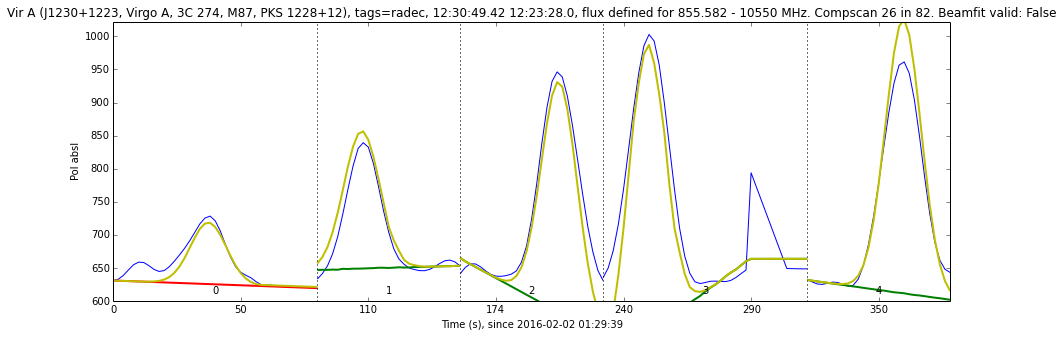

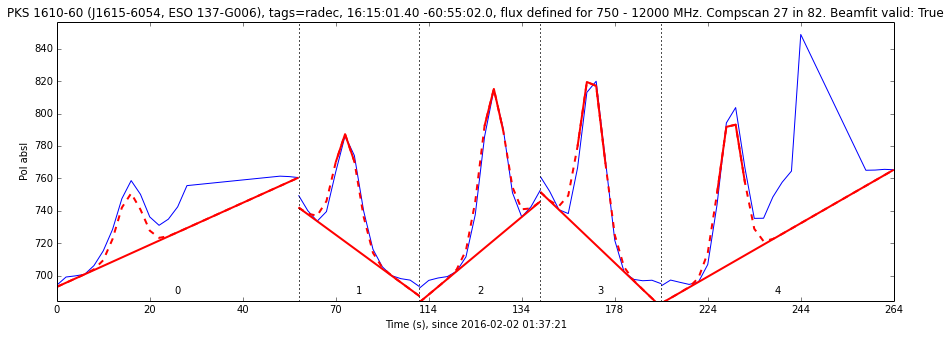

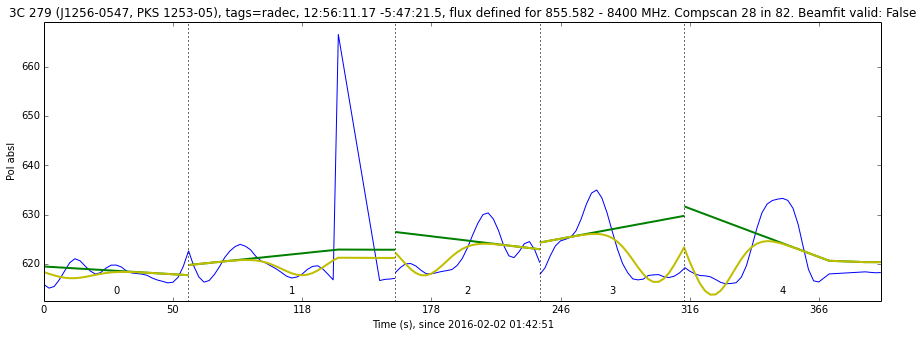

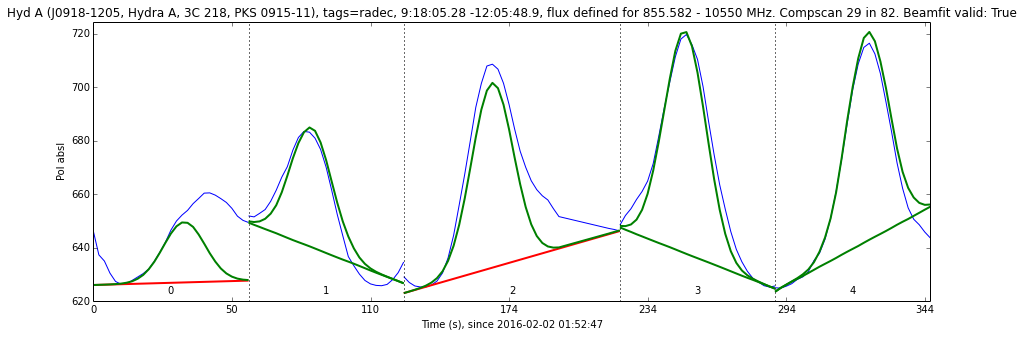

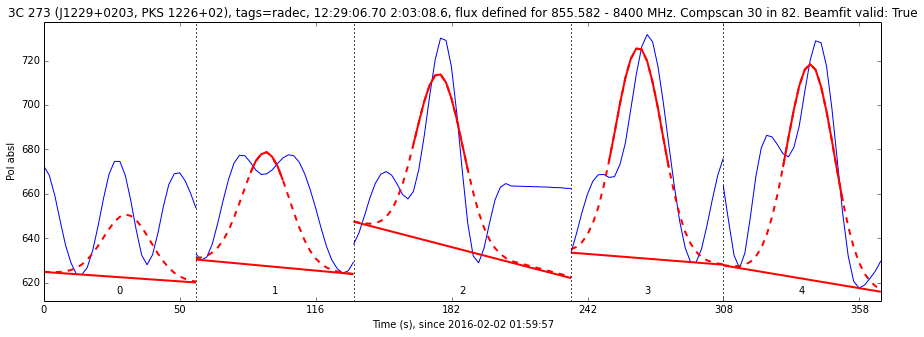

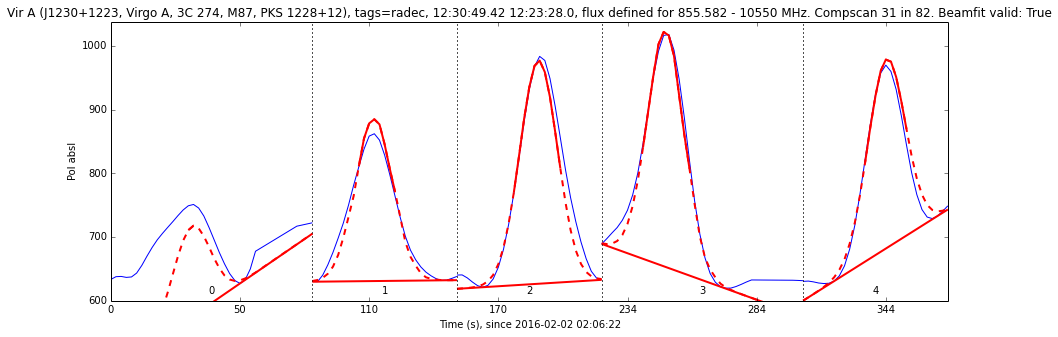

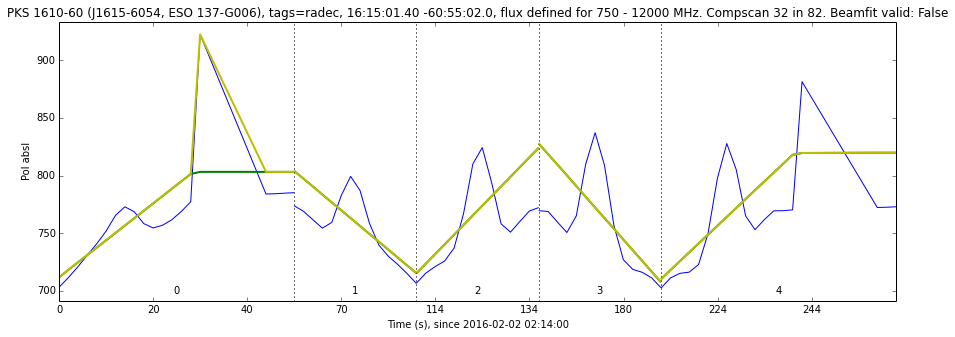

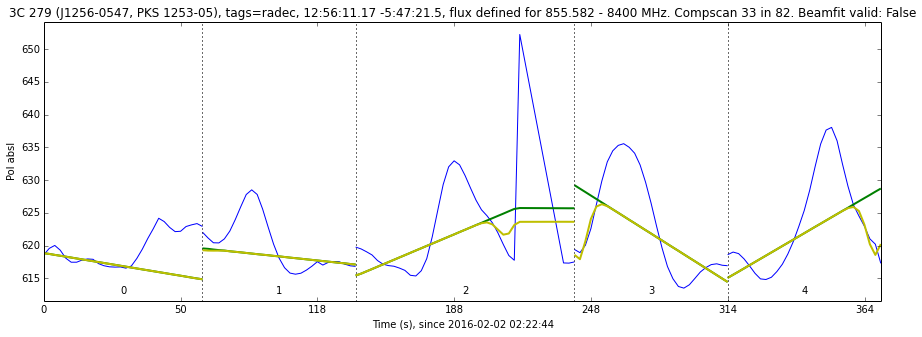

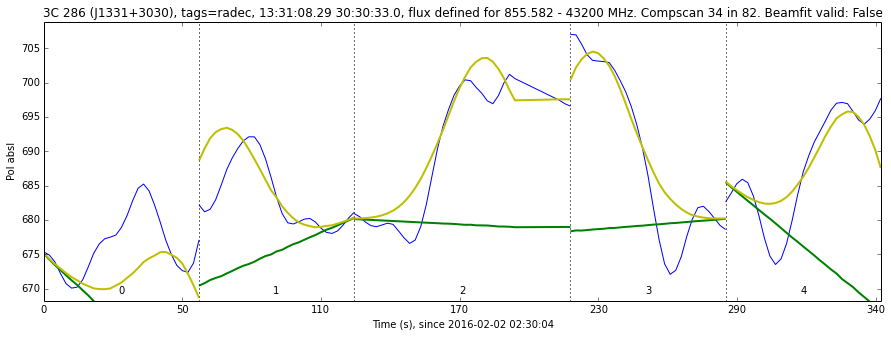

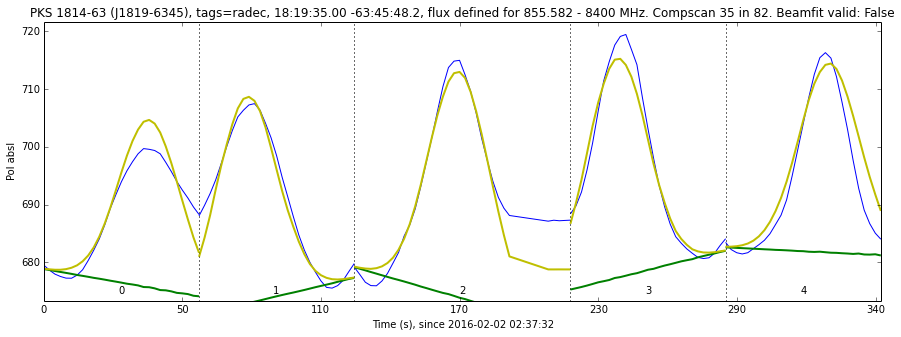

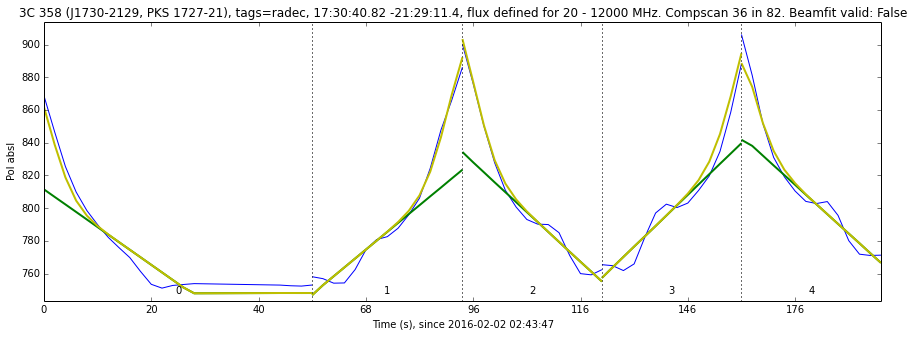

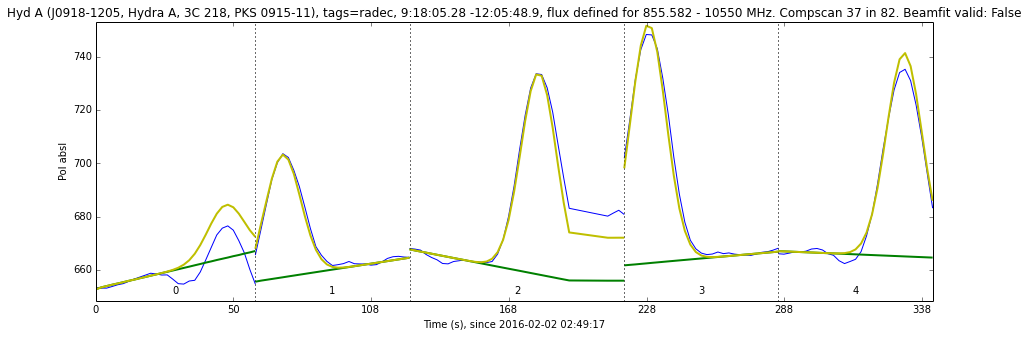

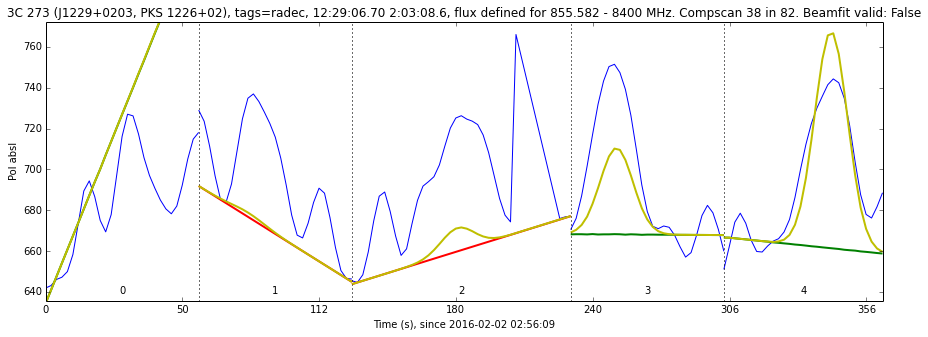

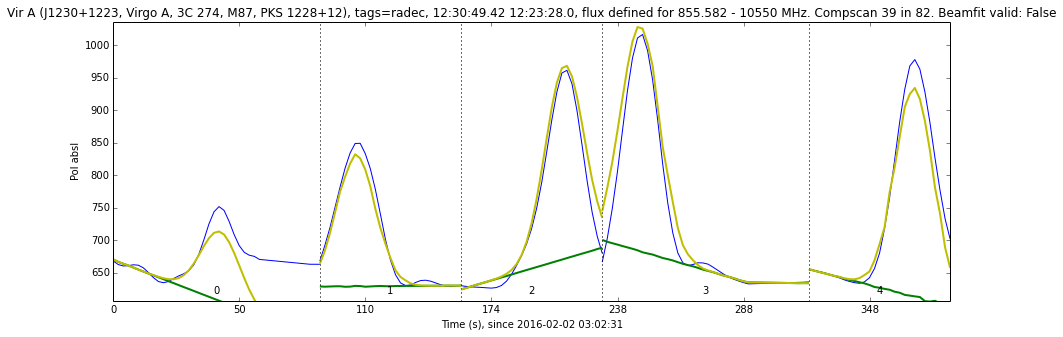

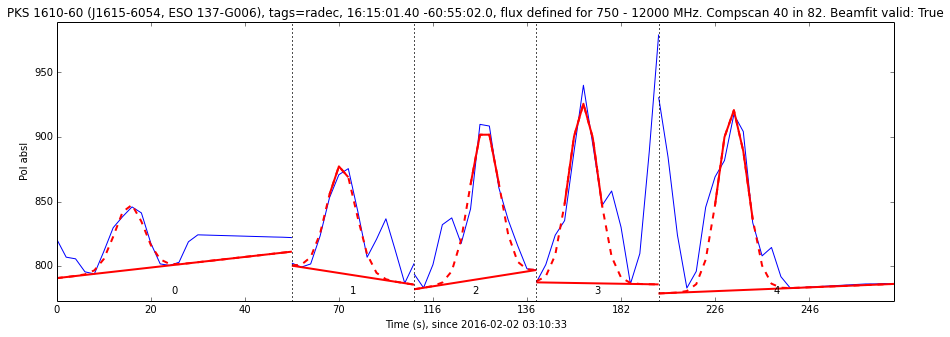

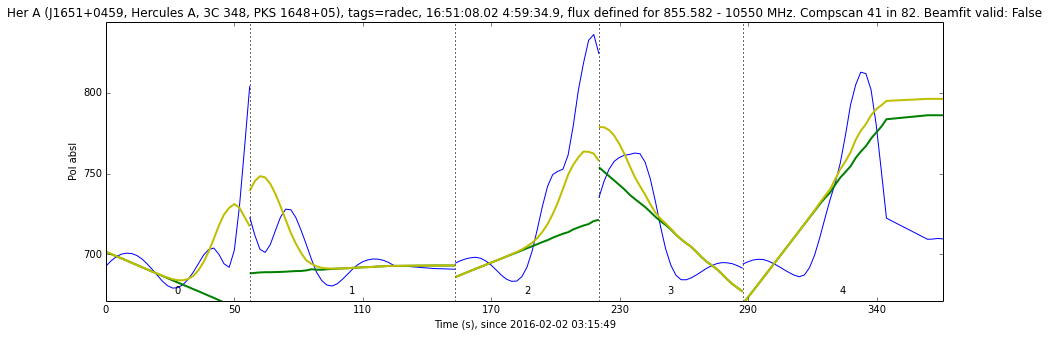

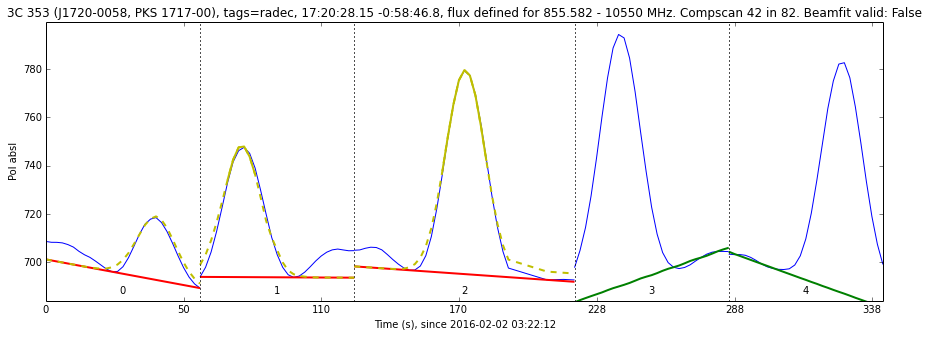

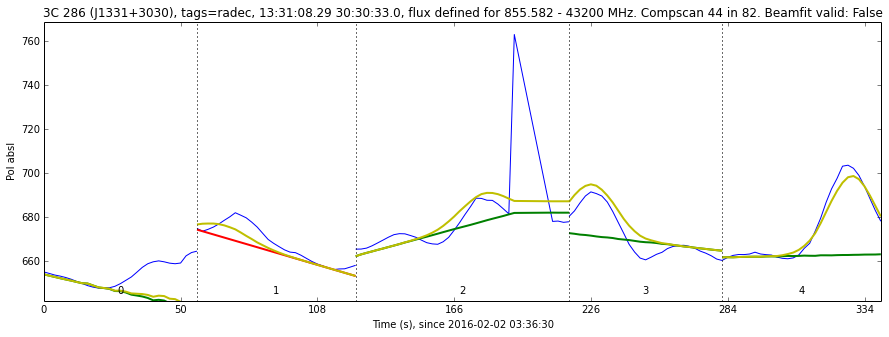

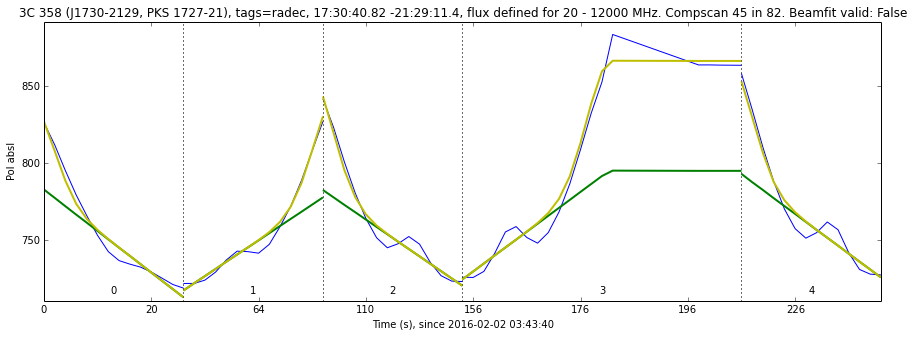

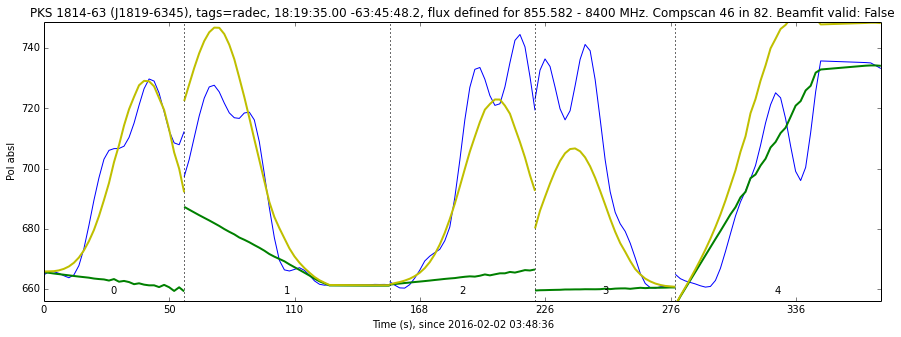

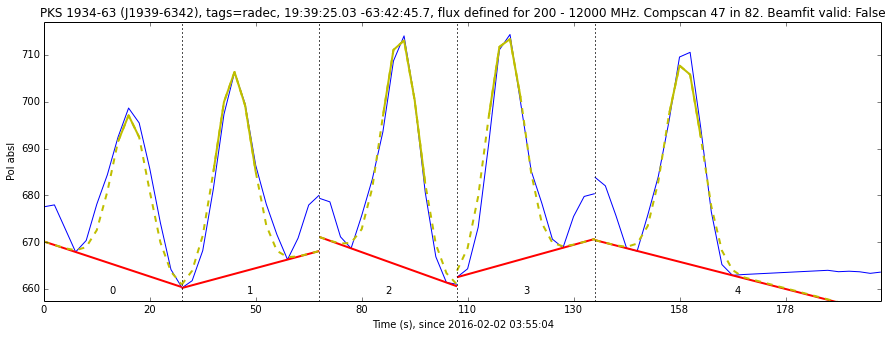

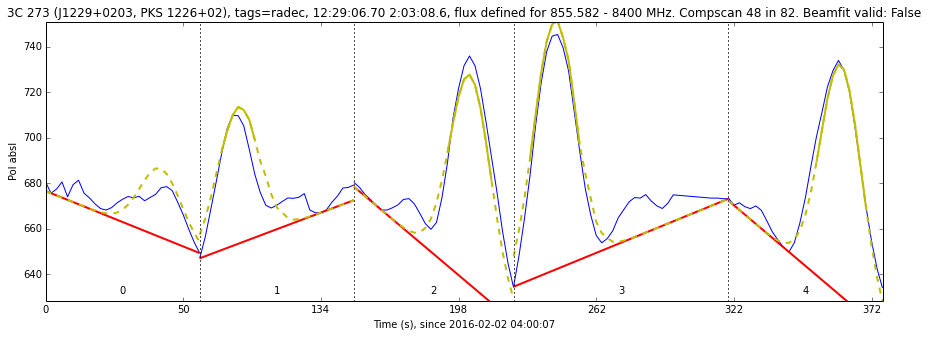

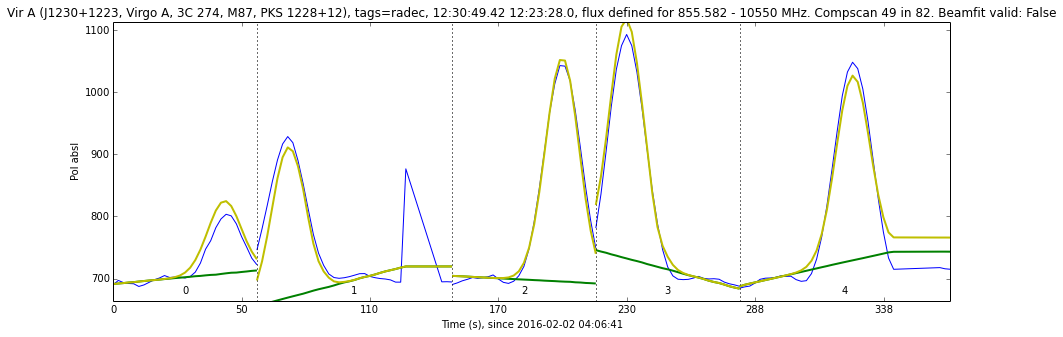

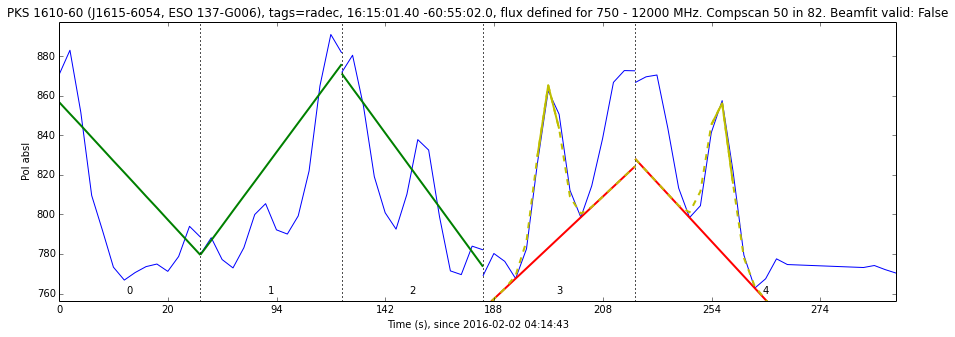

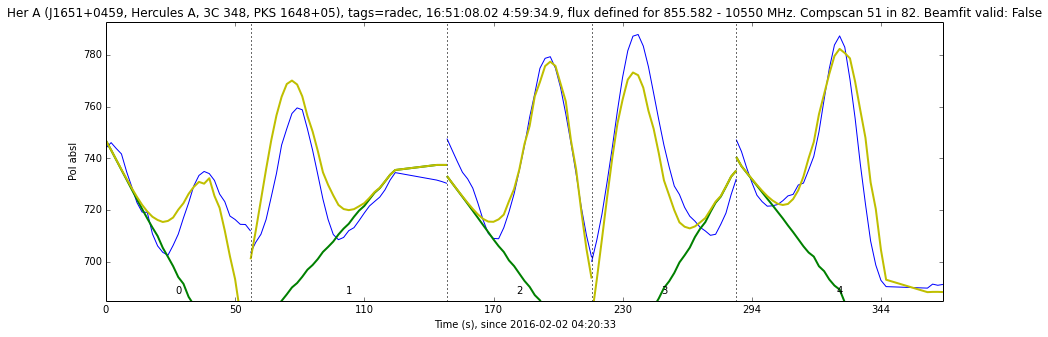

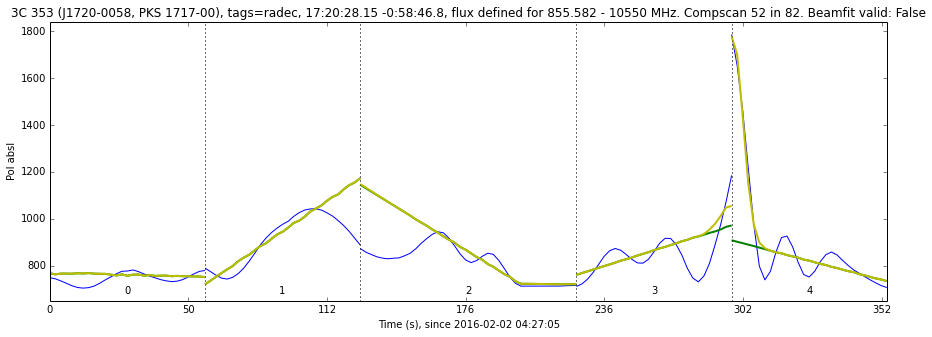

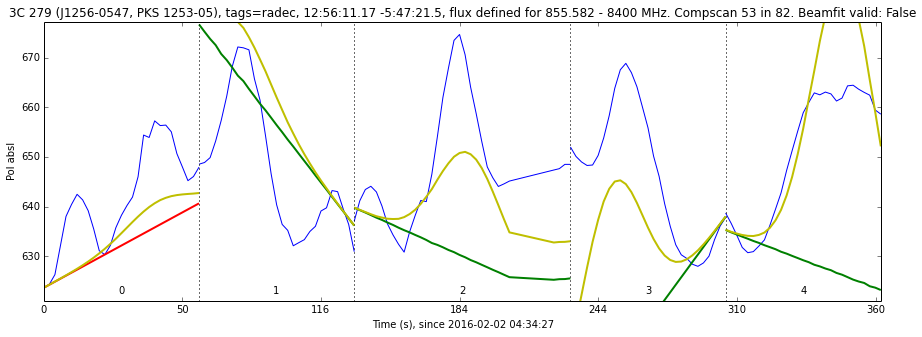

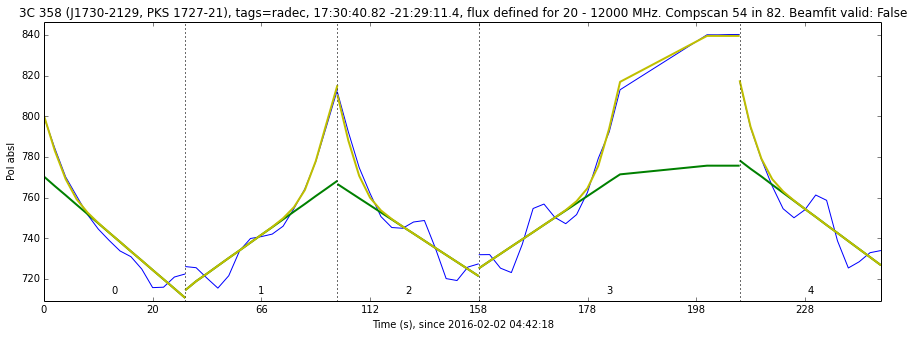

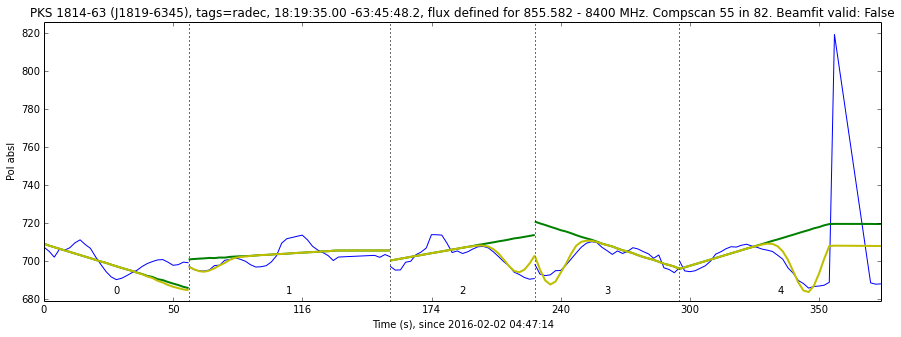

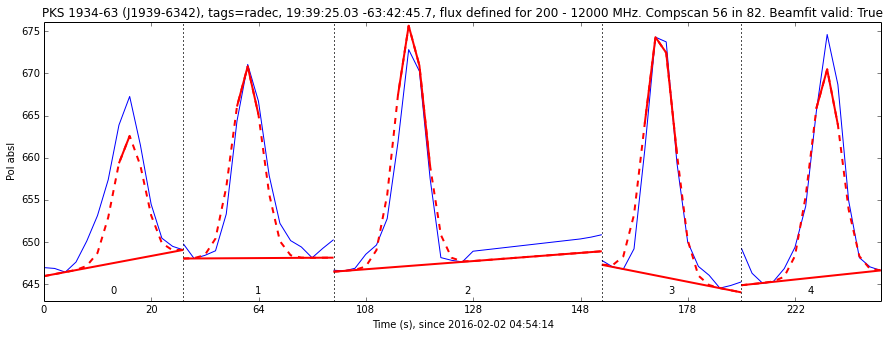

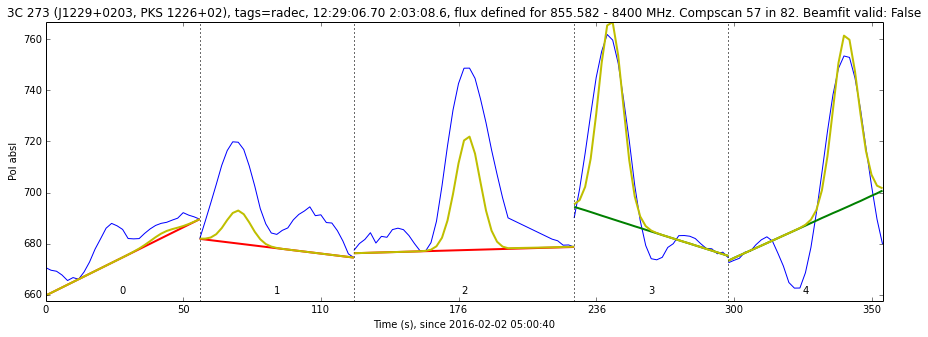

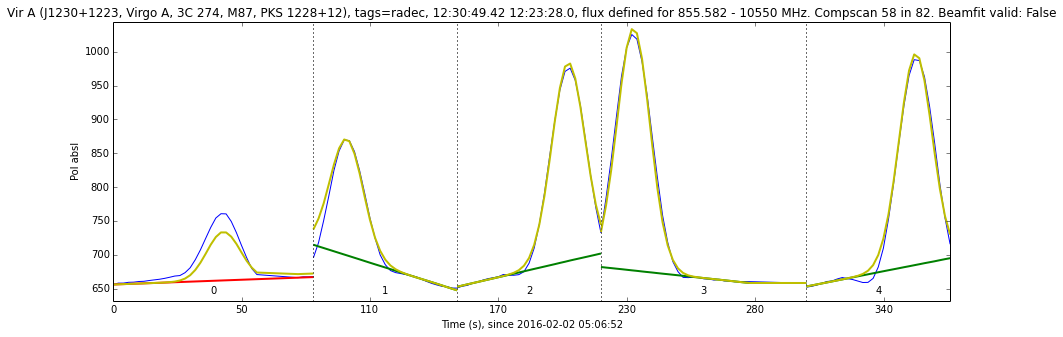

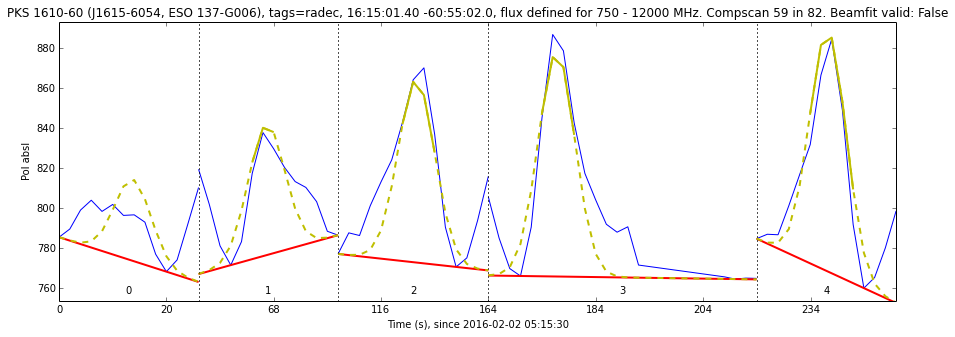

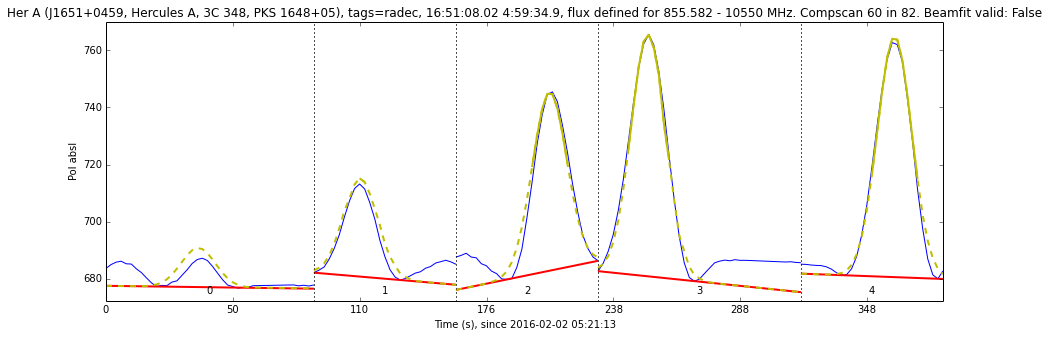

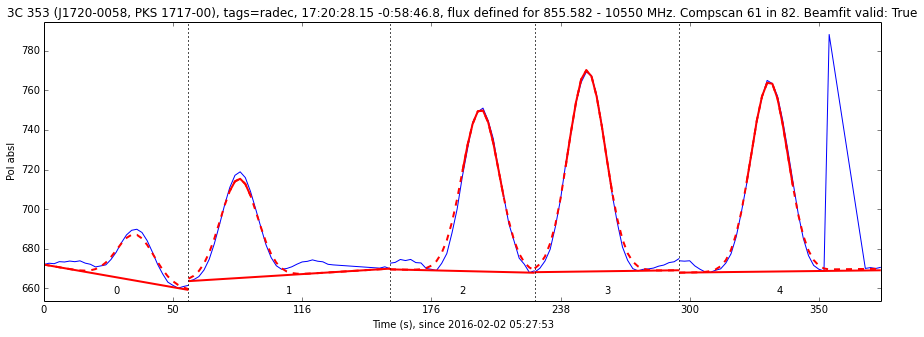

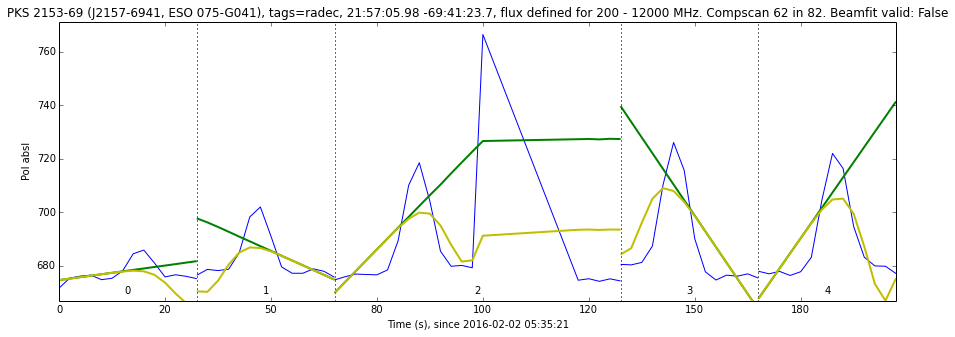

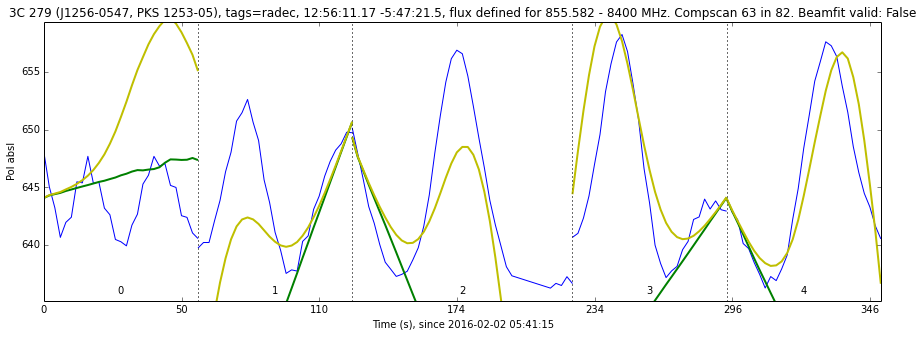

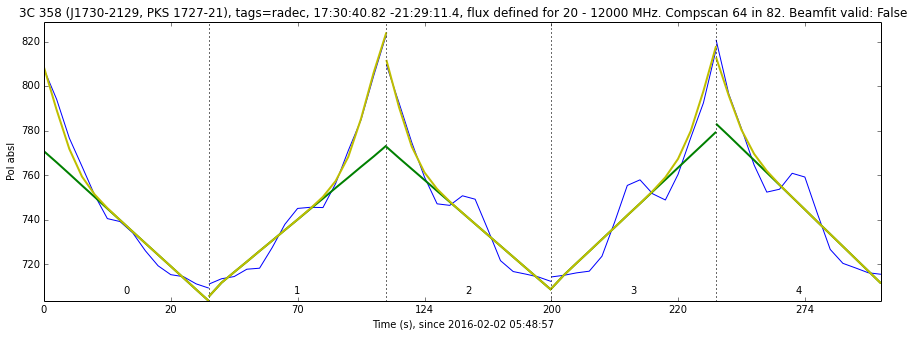

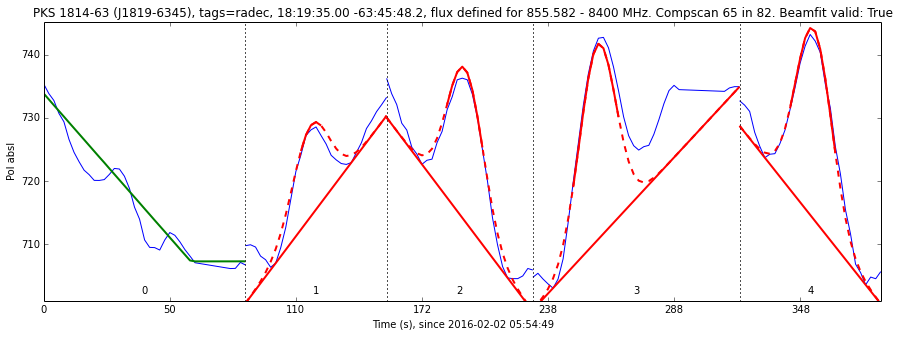

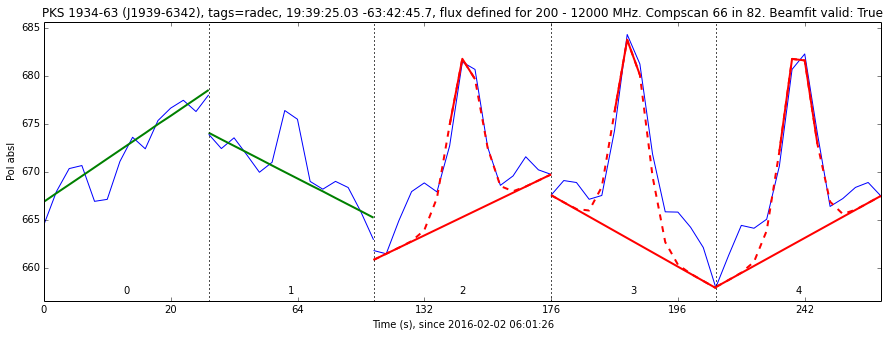

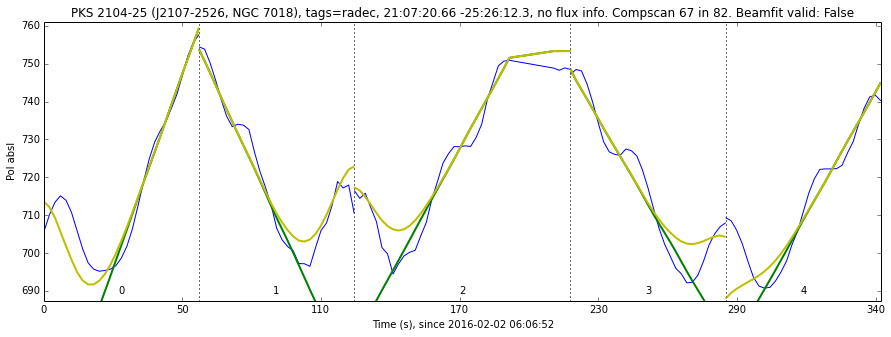

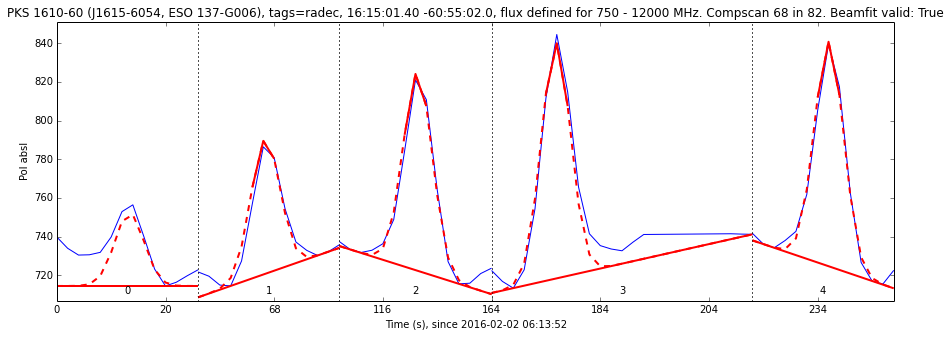

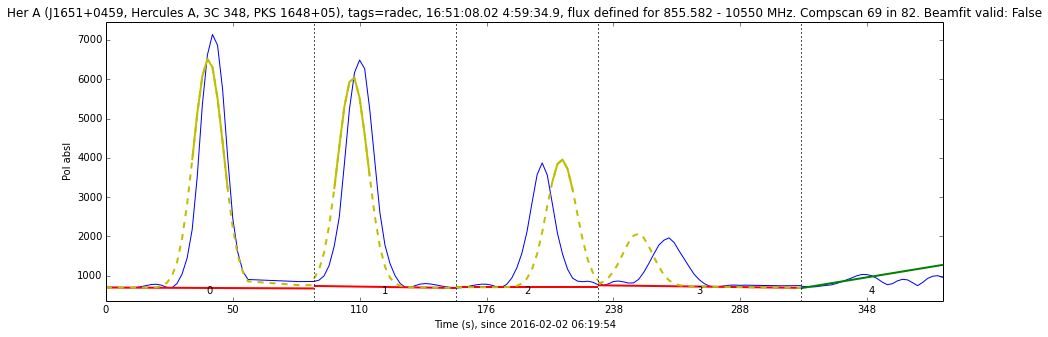

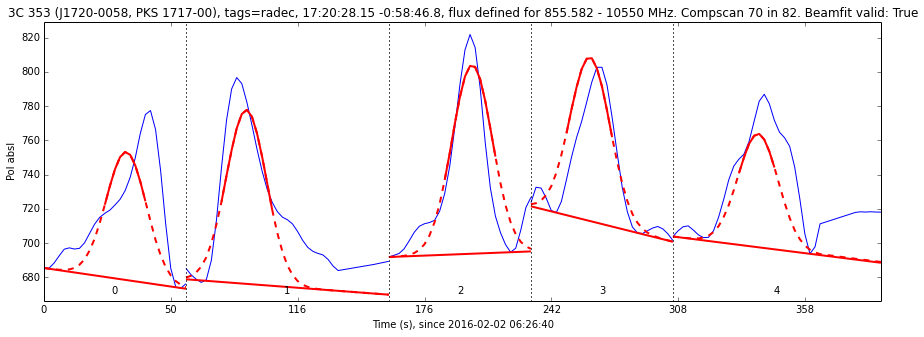

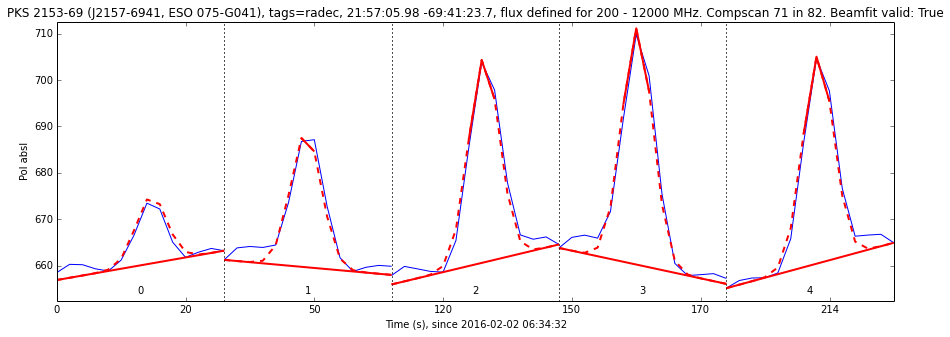

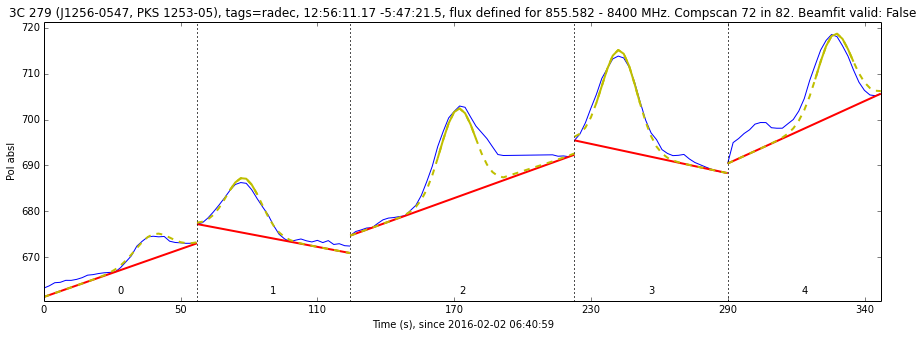

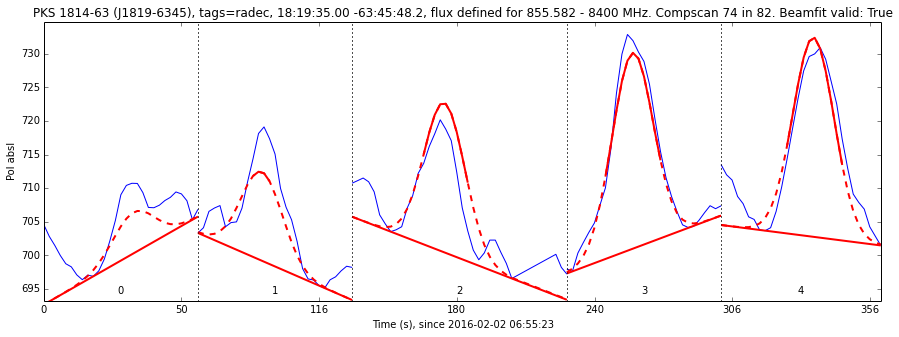

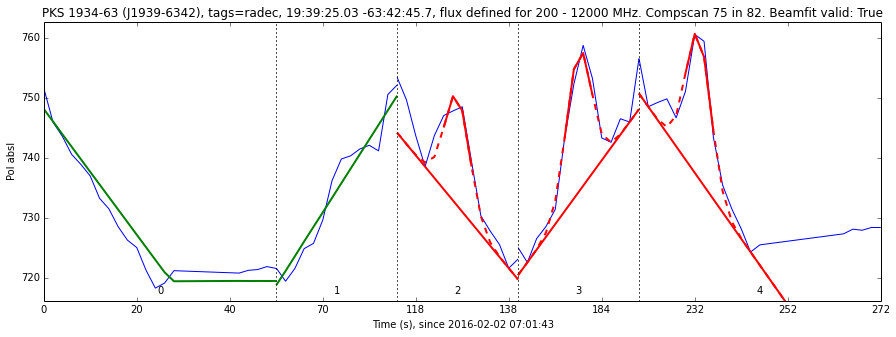

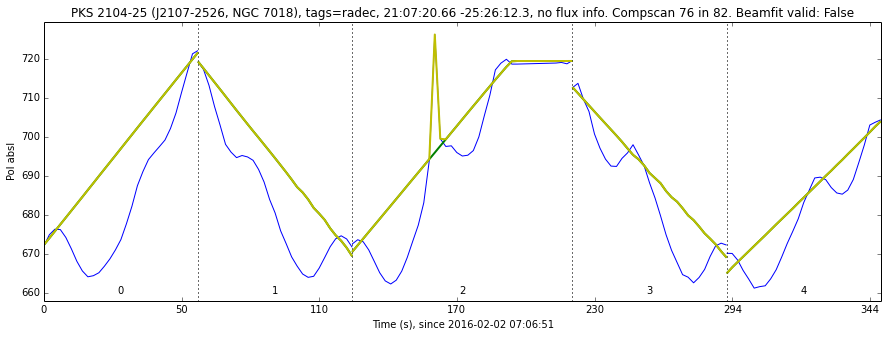

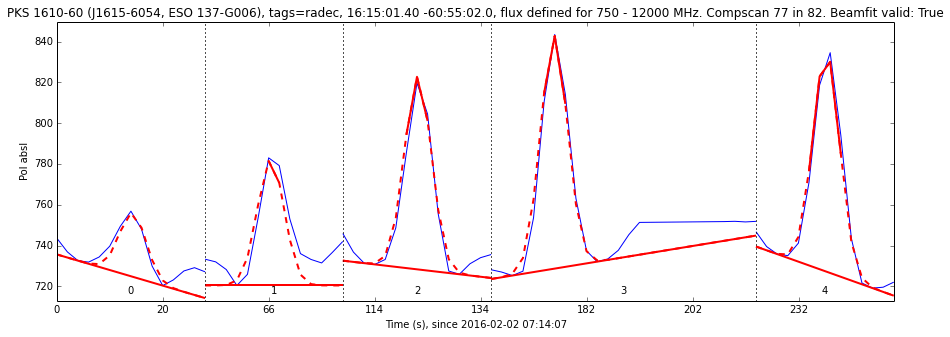

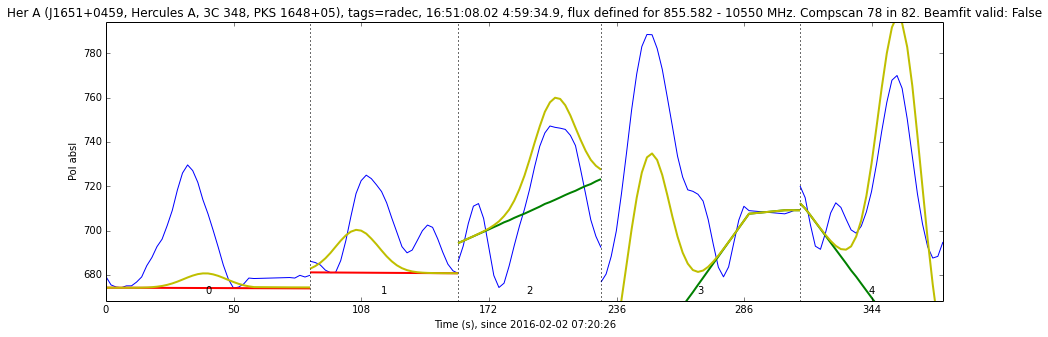

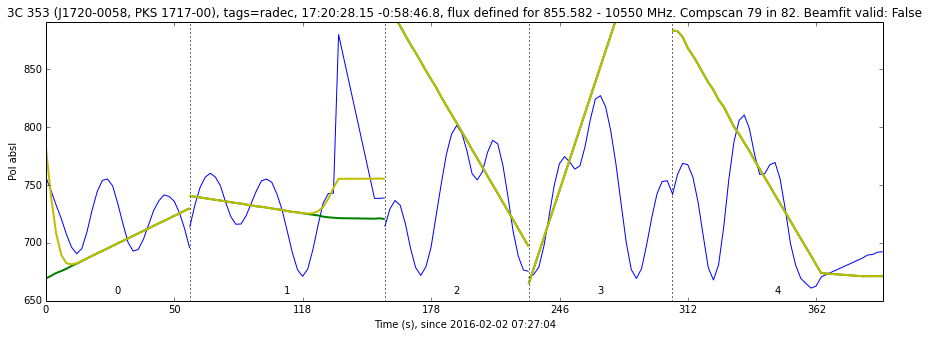

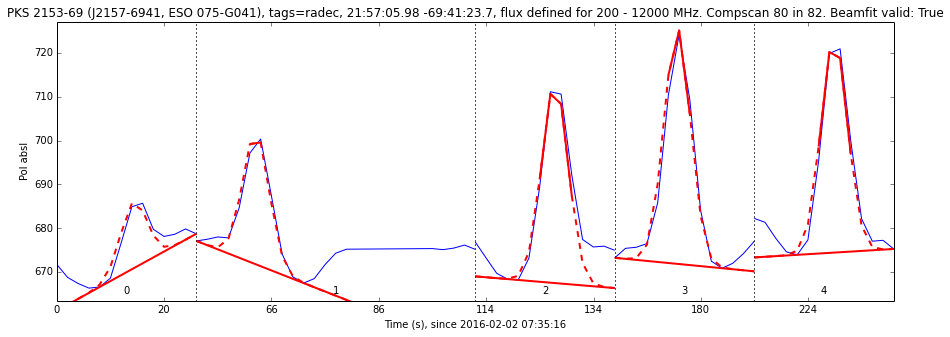

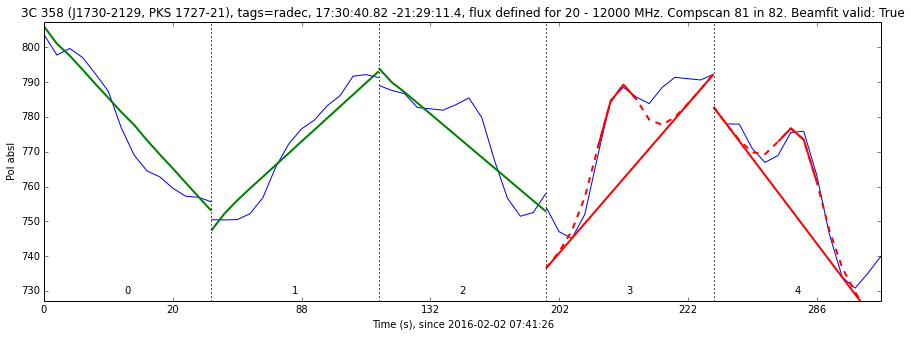

In [5]:
h5.select(reset='T')
N = len(h5.compscan_indices)
#h5.select(scans='scan',channels=slice(1024,1024+2048))
h5.select(ants=antenna_name, scans='scan', channels=slice(1024,1024+2048))
ant = h5.ants[0]
for c in h5.compscans():
#    d = scape.DataSet(h5)
    d = scape.DataSet(h5, baseline="%s" % (ant.name,), nd_models=nd_models)
    if not d is None:
        d = d.select(flagkeep='~nd_on')
    for i in range(len(d.scans)):
        d.scans[i].data = scape.stats.remove_spikes(d.scans[i].data,axis=1,spike_width=3,outlier_sigma=5.)    
    d.average()
    d.fit_beams_and_baselines()
    if d.compscans[0].beam == None:
        continue
    if True: #d.compscans[0].beam.is_valid:
        figure(figsize=(15,5))
        scape.plot_compound_scan_in_time(d.compscans[0])
        title(str(d.compscans[0].target) + '. Compscan %d in %d'%(c[0],N) + '. Beamfit valid: %s'%str(d.compscans[0].beam.is_valid))
    

#Output and Report

In [6]:
# Default output file names are based on input file name
dataset_name = os.path.splitext(os.path.basename(filename))[0]
outfilebase = '%s_%s_point_source_scans' % (dataset_name,antenna_name)
from matplotlib.backends.backend_pdf import PdfPages
# Generate output report
with PdfPages(outfilebase+'.pdf') as pdf:
    pagetext  = "\nPoint Observation"
    pagetext += "\n\nDescription: %s\nName: %s\nExperiment ID: %s" %(h5.description, h5.name, h5.experiment_id)
    pagetext  = pagetext + "\n"
    pagetext += "\n\nTest Setup:"
    pagetext += "\nRaster Scan across bright source"
    pagetext += "\n\nAntenna %s" % antenna_name
    pagetext += "\n------------"
    pagetext  = pagetext + "\n"

    plt.figure(None,figsize = (16,8))
    plt.axes(frame_on=False)
    plt.xticks([])
    plt.yticks([])
    plt.title("AR1 Report %s"%outfilebase ,fontsize=14, fontweight="bold")
    plt.text(0,0,pagetext,fontsize=12)
    pdf.savefig()
    plt.close()

    h5.select(reset='T')
    N = len(h5.compscan_indices)
    h5.select(ants=antenna_name, scans='scan', channels=slice(1024,1024+2048))
    ant = h5.ants[0]
    for c in h5.compscans():
        d = scape.DataSet(h5, baseline="%s" % (ant.name,), nd_models=nd_models)
        if not d is None:
            d = d.select(flagkeep='~nd_on')
        for i in range(len(d.scans)):
            d.scans[i].data = scape.stats.remove_spikes(d.scans[i].data,axis=1,spike_width=3,outlier_sigma=5.)    
        d.average()
        d.fit_beams_and_baselines()
        if d.compscans[0].beam == None:
            continue
        if True: #d.compscans[0].beam.is_valid:
            plt.figure(figsize=(15,5))
            scape.plot_compound_scan_in_time(d.compscans[0])
            plt.title(str(d.compscans[0].target) + '. Compscan %d in %d'%(c[0],N) + '. Beamfit valid: %s'%str(d.compscans[0].beam.is_valid))
            pdf.savefig()
            plt.close()

    d = pdf.infodict()
    import datetime
    d['Title'] = h5.description
    d['Author'] = 'AR1'
    d['Subject'] = 'AR1 Pointing Observation'
    d['CreationDate'] = datetime.datetime(2015, 8, 13)
    d['ModDate'] = datetime.datetime.today()